In [1]:
import warnings
from pandas import read_csv, DataFrame
from datetime import datetime
from matplotlib import pyplot
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt

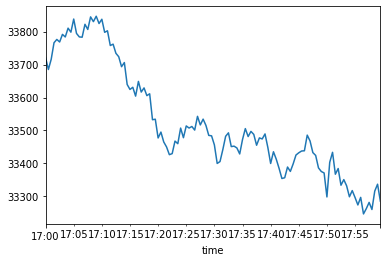

In [2]:
series_test = read_csv('./Data/Processed_BT_PriceDB_test.csv', header=0, parse_dates=[0], index_col=0, squeeze=True)
series_test.plot()
pyplot.show()

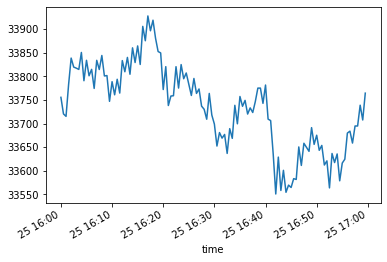

In [3]:
series_train = read_csv('./Data/Processed_BT_PriceDB_train.csv', header=0, parse_dates=[0], index_col=0, squeeze=True)
series_train.plot()
pyplot.show()

In [7]:
def evaluate_arima_model(arima_order):
    history = [x for x in series_train.values]
    test = [x for x in series_test[:11].values]
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    rmse = sqrt(mean_squared_error(test, predictions))
    return rmse


# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(p_values, d_values, q_values):
	best_score, best_cfg = float("inf"), None
	for p in p_values:
		for d in d_values:
			for q in q_values:
				order = (p,d,q)
				try:
					mse = evaluate_arima_model(order)
					if mse < best_score:
						best_score, best_cfg = mse, order
					print('ARIMA%s RMSE=%.3f' % (order,mse))
				except:
					continue
	print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

In [8]:
p_values = [0, 1, 2, 4, 6, 8, 10]
d_values = range(0, 4)
q_values = range(0, 4)
warnings.filterwarnings("ignore")
evaluate_models(p_values, d_values, q_values)

ARIMA(0, 0, 0) RMSE=53.490
ARIMA(0, 0, 1) RMSE=41.621
ARIMA(0, 0, 2) RMSE=44.123
ARIMA(0, 0, 3) RMSE=45.838
ARIMA(0, 1, 0) RMSE=29.947
ARIMA(0, 1, 1) RMSE=29.692
ARIMA(0, 1, 2) RMSE=34.169
ARIMA(0, 1, 3) RMSE=34.968
ARIMA(0, 2, 0) RMSE=46.923
ARIMA(0, 2, 1) RMSE=29.900
ARIMA(0, 2, 2) RMSE=29.481
ARIMA(0, 2, 3) RMSE=33.968
ARIMA(0, 3, 0) RMSE=85.872
ARIMA(0, 3, 1) RMSE=47.099
ARIMA(0, 3, 2) RMSE=29.024
ARIMA(0, 3, 3) RMSE=31.650
ARIMA(1, 0, 0) RMSE=30.222
ARIMA(1, 0, 1) RMSE=30.172
ARIMA(1, 0, 2) RMSE=34.169
ARIMA(1, 0, 3) RMSE=35.913
ARIMA(1, 1, 0) RMSE=32.956
ARIMA(1, 1, 1) RMSE=33.061
ARIMA(1, 1, 2) RMSE=33.739
ARIMA(1, 1, 3) RMSE=33.930
ARIMA(1, 2, 0) RMSE=44.258
ARIMA(1, 2, 1) RMSE=35.899
ARIMA(1, 2, 2) RMSE=32.692
ARIMA(1, 2, 3) RMSE=33.438
ARIMA(1, 3, 0) RMSE=64.564
ARIMA(1, 3, 1) RMSE=43.650
ARIMA(1, 3, 2) RMSE=36.062
ARIMA(1, 3, 3) RMSE=30.913
ARIMA(2, 0, 0) RMSE=33.303
ARIMA(2, 0, 1) RMSE=33.096
ARIMA(2, 0, 2) RMSE=34.162
ARIMA(2, 0, 3) RMSE=34.268
ARIMA(2, 1, 0) RMSE=35.371
A

In [10]:
predictions = list()
history = [x for x in series_train.values]
test = [x for x in series_test.values]
# walk-forward validation
for t in range(len(test)):
    model = ARIMA(history, order=(0,3,2))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs) # add the actual value back in the model

Test RMSE: 32.238


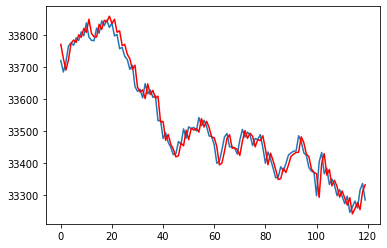

In [11]:
# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

In [13]:
import psycopg2
conn = psycopg2.connect(database="postgres", user="postgres", password="Aa@123456", host="127.0.0.1", port="5432")
cur = conn.cursor()
cur.execute('''SELECT to_timestamp(floor((extract('epoch' from Created_at) / 30 )) * 30) AT TIME ZONE 'UTC' time_ , avg(price) price_
                    FROM BT_Price
                    WHERE created_at <= date_trunc('hour',  now() + interval '1 hour') and created_at >= (now() - interval '1 hour')
                    GROUP BY time_ 
                    ORDER BY time_''')
rows = cur.fetchall()

In [24]:
conn.commit()

In [21]:
df = DataFrame(rows, columns=['time','price'])
df

,time,price
0,2021-06-26 21:47:30,32348.80000
1,2021-06-26 21:48:00,31960.82445
2,2021-06-26 21:48:30,31978.72835
3,2021-06-26 21:49:00,31974.80370
4,2021-06-26 21:49:30,31974.30835
...,...,...
116,2021-06-26 22:45:30,31956.21765
117,2021-06-26 22:46:00,31951.61585
118,2021-06-26 22:46:30,31960.55700
119,2021-06-26 22:47:00,31954.53085


In [22]:
df["price"].values

array([32348.8    , 31960.82445, 31978.72835, 31974.8037 , 31974.30835,
       31985.8398 , 31981.52085, 31986.32385, 31998.75105, 32004.02665,
       31993.87735, 31998.41085, 31967.4783 , 31971.82085, 31968.47565,
       31963.16085, 31930.75125, 31926.6225 , 31912.2495 , 31921.55665,
       31922.86845, 31936.9625 , 32348.8    , 31943.2205 , 31948.04165,
       31949.56385, 31973.53   , 31990.9945 , 32007.24085, 32053.82055,
       32043.69165, 32016.8539 , 32004.03915, 32004.33025, 31996.47165,
       31993.71085, 31993.71085, 32017.82545, 32021.72085, 32033.77995,
       32041.56665, 31702.417  , 32026.03665, 32031.35965, 32057.58915,
       32054.0234 , 32054.21165, 32029.61835, 32036.78335, 32007.072  ,
       32007.61415, 32010.77225, 32005.43165, 32011.35495, 32016.16835,
       32015.83085, 32027.29165, 32008.795  , 31982.15415, 31975.4721 ,
       31975.51155, 31981.41085, 31981.41085, 31982.05585, 31993.60535,
       32000.745  , 31985.33875, 31982.43585, 31982.2056 , 31993

In [36]:
cur = conn.cursor()
cur.execute('''SELECT to_timestamp(floor((extract('epoch' from Created_at) / 30 )) * 30) AT TIME ZONE 'UTC' time_ , avg(price) price_
                    FROM BT_Price
                    WHERE created_at <= date_trunc('hour',  now() + interval '1 hour') and created_at >= (now() - interval '1 hour')
                    GROUP BY time_ 
                    ORDER BY time_''')
rows = cur.fetchall()
conn.commit()

res = {}
df = DataFrame(rows, columns=['time','price'])

history = [x for x in df["price"].values]
model = ARIMA(history, order=(0,3,2))
model_fit = model.fit()
output = model_fit.forecast()
yhat = output[0]

current_time = datetime.now()
if current_time.second < 30:
    newdatetime = current_time.replace(second=(current_time.second + 30), microsecond=0)
else:
    newdatetime = current_time.replace(minute=(current_time.minute + 1), second=0, microsecond=0)
str(newdatetime)

res["datetime"] = str(newdatetime)
res["price"] = yhat

cur = conn.cursor()
cur.execute(f"INSERT INTO BTC_Price_Prediction (created_at,price) VALUES ('{str(newdatetime)}', {yhat})")
conn.commit()

res

{'datetime': '2021-06-26 22:58:00', 'price': 31945.051281606804}